In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
import statsmodels.api as sm
import scipy.stats as scs
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('./data/adult.data')
cols = ['workclass', 'sex', 'age', 'education_num', 'capital_gain',
        'capital_loss', 'hours_per_week', 'label']
data = data[cols]
data['label_code'] = pd.Categorical(data.label).codes

In [3]:
# 将数据分为训练集和测试集
train_set, test_set = train_test_split(data, test_size=0.2, random_state=2310)

In [4]:
def trans_feature(data, category):
    '''
    根据传入的分段区间，将每星期工作时间转换为定量变量

    参数
    ----
    data : DataFrame，建模数据

    category : list，分段区间
    '''
    labels = ['{0}-{1}'.format(category[i], category[i+1]) for i in range(len(category) - 1)]
    data.loc[:, 'hours_per_week_group'] = pd.cut(
        data['hours_per_week'], category, include_lowest=True, labels=labels)
    return data

In [5]:
def make_prediction(re, test_set, alpha=0.5):
    '''
    使用训练好的模型对测试数据做预测
    '''
    # 关闭pandas有关chain_assignment的警告
    pd.options.mode.chained_assignment = None
    # 计算事件发生的概率
    data = test_set.copy()
    data['prob'] = re.predict(data)
    # 根据预测的概率，得出最终的预测
    data['pred'] = data.apply(lambda x: 1 if x['prob'] > alpha else 0, axis=1)
    return data

In [6]:
def _auc(re):
    fpr, tpr, _ = metrics.roc_curve(re['label_code'], re['prob'])
    auc = metrics.auc(fpr, tpr)
    return fpr, tpr, auc


def evaluation(new_re, base_re):
    '''
    展示将每星期工作时间离散化之后，模型效果的变化
    '''
    fpr, tpr, auc = _auc(new_re)
    # 为在Matplotlib中显示中文，设置特殊字体
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.rcParams.update({'font.size': 13})
    # 创建一个图形框
    fig = plt.figure(figsize=(6, 6), dpi=100)
    # 在图形框里只画一幅图
    ax = fig.add_subplot(111)
    ax.set_title('ROC曲线')
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    ax.plot([0, 1], [0, 1], 'r--')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.plot(fpr, tpr, 'k', label=f'转换后的ROC曲线; AUC = {auc:0.3f}')
    # 绘制原模型的ROC曲线
    fpr, tpr, auc = _auc(base_re)
    ax.plot(fpr, tpr, 'b-.', label=f'直接使用的ROC曲线; AUC = {auc:0.3f}')
    legend = plt.legend(shadow=True)
    return fig

In [7]:
# 直接使用，基准模型
formula = 'label_code ~ education_num + capital_gain + capital_loss + hours_per_week'
model = sm.Logit.from_formula(formula, data=train_set)
re = model.fit()
base_res = make_prediction(re, test_set)
print(re.summary())

Optimization terminated successfully.
         Current function value: 0.426128
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:             label_code   No. Observations:                26048
Model:                          Logit   Df Residuals:                    26043
Method:                           MLE   Df Model:                            4
Date:                Mon, 06 Nov 2023   Pseudo R-squ.:                  0.2276
Time:                        22:27:30   Log-Likelihood:                -11100.
converged:                       True   LL-Null:                       -14370.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -6.4633      0.105    -61.684      0.000      -6.669      -6.258
education_num    

In [8]:
# 将每星期工作时间平均划分成5份
category5 = range(0, 105, 20)
train_data = trans_feature(train_set, category5)
test_data = trans_feature(test_set, category5)
formula = 'label_code ~ education_num + capital_gain + capital_loss + C(hours_per_week_group)'
model = sm.Logit.from_formula(formula, data=train_data)
re = model.fit()
category5_res = make_prediction(re, test_data)
print(re.summary())

Optimization terminated successfully.
         Current function value: 0.423736
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:             label_code   No. Observations:                26048
Model:                          Logit   Df Residuals:                    26040
Method:                           MLE   Df Model:                            7
Date:                Mon, 06 Nov 2023   Pseudo R-squ.:                  0.2319
Time:                        22:27:31   Log-Likelihood:                -11037.
converged:                       True   LL-Null:                       -14370.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -6.1776      0.125    -49

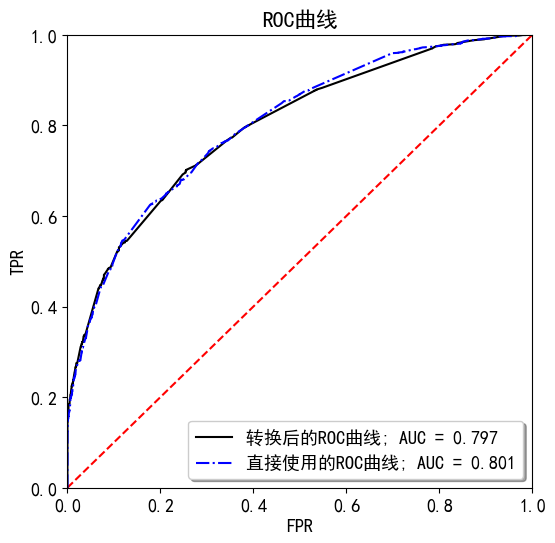

In [9]:
# 展示模型结果
re = evaluation(category5_res, base_res)
re.savefig('continous_var_cut_5.png', dpi=200)

In [10]:
# 将每星期工作时间平均划分成10份
category10 = range(0, 105, 10)
train_data = trans_feature(train_set, category10)
test_data = trans_feature(test_set, category10)
formula = 'label_code ~ education_num + capital_gain + capital_loss + C(hours_per_week_group)'
model = sm.Logit.from_formula(formula, data=train_data)
re = model.fit()
category10_res = make_prediction(re, test_data)
print(re.summary())

Optimization terminated successfully.
         Current function value: 0.420426
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:             label_code   No. Observations:                26048
Model:                          Logit   Df Residuals:                    26035
Method:                           MLE   Df Model:                           12
Date:                Mon, 06 Nov 2023   Pseudo R-squ.:                  0.2379
Time:                        22:27:31   Log-Likelihood:                -10951.
converged:                       True   LL-Null:                       -14370.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -5.8862      0.181    -32

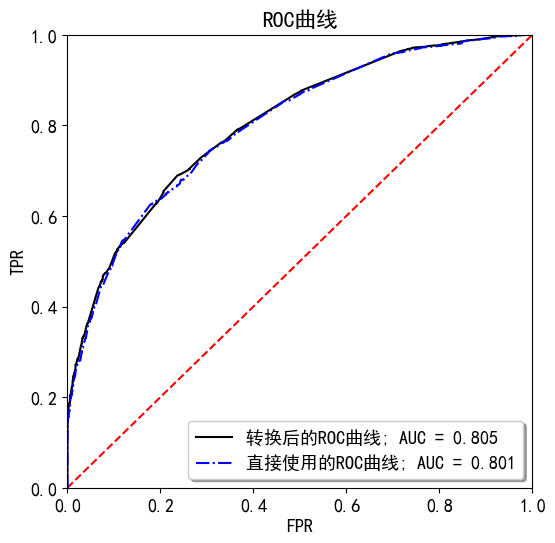

In [11]:
# 展示模型结果
re = evaluation(category10_res, base_res)
re.savefig('continous_var_cut_10.png', dpi=200)

In [12]:
def get_category(data):
    '''
    基于卡方检验，得到每星期工作时间的最优分段
    '''
    interval = [data['hours_per_week'].min(), data['hours_per_week'].max()]
    _category = do_divide(data, interval)
    s = set()
    for i in _category:
        s = s.union(set(i))
    category = list(s)
    category.sort()
    return category

def do_divide(data, interval):
    '''
    使用贪心算法，得到最优的分段
    '''
    category = []
    p_value, chi2, index = divide_data(data, interval[0], interval[1])
    if chi2 < 15:
        category.append(interval)
    else:
        category += do_divide(data, [interval[0], index])
        category += do_divide(data, [index, interval[1]])
    return category

def divide_data(data, min_value, max_value):
    '''
    遍历所有可能的分段，返回卡方统计量最高的分段
    '''
    max_chi2 = 0
    index = -1
    max_p_value = 0
    for i in range(min_value + 1, max_value):
        category = pd.cut(data['hours_per_week'], [min_value, i, max_value],
                          include_lowest=True)
        cross = pd.crosstab(data['label'], category)
        chi2, p_value, _, _ = scs.chi2_contingency(cross)
        if chi2 > max_chi2:
            max_p_value = p_value
            max_chi2 = chi2
            index = i
    return max_p_value, max_chi2, index

In [13]:
# 基于卡方检验划分区间
category_chi2 = get_category(train_set)
train_data = trans_feature(train_set, category_chi2)
test_data = trans_feature(test_set, category_chi2)
formula = 'label_code ~ education_num + capital_gain + capital_loss + C(hours_per_week_group)'
model = sm.Logit.from_formula(formula, data=train_data)
re = model.fit()
category_chi2_res = make_prediction(re, test_data)
print(re.summary())

Optimization terminated successfully.
         Current function value: 0.419160
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:             label_code   No. Observations:                26048
Model:                          Logit   Df Residuals:                    26040
Method:                           MLE   Df Model:                            7
Date:                Mon, 06 Nov 2023   Pseudo R-squ.:                  0.2402
Time:                        22:27:43   Log-Likelihood:                -10918.
converged:                       True   LL-Null:                       -14370.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -6.1007      0.107    -57.08

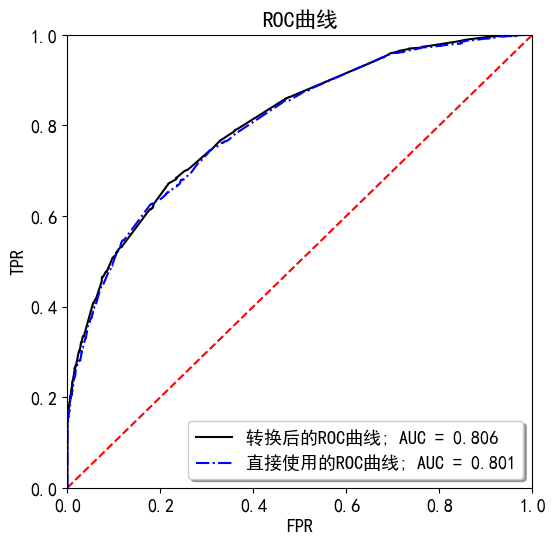

In [14]:
# 展示模型结果
re = evaluation(category_chi2_res, base_res)
re.savefig('continous_var_cut_chi2.png', dpi=200)